In [1]:
!pip install -U rasterio opencv-python pyproj geopandas shapely --upgrade --no-binary shapely geopandas
!apt update && apt install -y gdal-bin
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.2 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import geopandas as gpd
import rasterio
import glob
from rasterio.windows import Window
from rasterio import warp
import cv2
from shapely.geometry import *
from urllib.parse import urlparse
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import geopandas as gpd
import rasterio
from shapely.geometry import Polygon
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.preprocessing.image
from sklearn.model_selection import train_test_split, ParameterGrid
from google.colab import drive # for mounting drive
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# --- Configuration ---
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/DronearthHass/"  # Change to your data path
IMAGES_DIR = DATA_PATH
LABELS_PATH = os.path.join(DATA_PATH, "labels.geojson")
OUTPUT_DIR = os.path.join(DATA_PATH, "Output/") # Save outputs to Drive
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 1
EPOCHS = 5
USE_PRETRAINED = True
PATCH_SIZE = (IMG_HEIGHT, IMG_WIDTH)
VALIDATION_SPLIT = 0.2





In [4]:
# Utility functions
def get_local_file_uri(file_path):
    file_path = os.path.abspath(file_path)
    return urlparse(f"file://{file_path}").geturl()

def create_geojson_from_polygons(polygons, output_path, crs="EPSG:4326"):
    gdf = gpd.GeoDataFrame({'geometry': [Polygon(poly) for poly in polygons]})
    gdf.crs = crs
    gdf.to_file(output_path, driver="GeoJSON")

def annotate_image(image_path, output_geojson_path):
    with rasterio.open(image_path) as src:
        # Calculate width and height of the quarter section
        width = src.width // 2
        height = src.height // 2

        # Read the lower-left quarter, handling different channel counts
        window = Window(0, src.height - height, width, height)
        if src.count == 1:
            img_data = src.read(1, window=window)  # Read single band
            img_data = np.expand_dims(img_data, axis=2)  # Add channel dimension
        else:
            img_data = src.read([1, 2, 3], window=window)
            img_data = np.moveaxis(img_data, 0, -1)

        # Convert to 8-bit for OpenCV compatibility
        img_data = (img_data * 255.0 / img_data.max()).astype(np.uint8)

        # Create a compatible OpenCV image (ensure contiguous data)
        img = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)

    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    print(f"Annotating: {image_path} (Lower-left quarter)")

    cv2.namedWindow("Image Annotation", cv2.WINDOW_NORMAL)
    polygons = []
    current_polygon = []

    def on_mouse(event, x, y, flags, param):
        nonlocal current_polygon, polygons
        if event == cv2.EVENT_LBUTTONDOWN:
            # Adjust coordinates to full image scale
            current_polygon.append([x + width, y + height])
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(current_polygon) > 2:
                polygons.append(current_polygon.copy())
                current_polygon = []
                # Adjust coordinates for drawing on the quarter image
                cv2.polylines(img, [np.array([[pt[0] - width, pt[1] - height] for pt in polygons[-1]], np.int32)],
                              True, (0, 255, 0), 2)
                cv2.imshow("Image Annotation", img)

    cv2.setMouseCallback("Image Annotation", on_mouse)

    print("Instructions:")
    print("- Left-click to add points to the polygon.")
    print("- Right-click to complete the current polygon.")
    print("- Press 'q' to finish annotation and save the GeoJSON.")

    while True:
        cv2.imshow("Image Annotation", img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    create_geojson_from_polygons(polygons, output_geojson_path)

# --- Data Loading and Preprocessing ---
def load_image_data(image_path, labels_path, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED):
    """Loads data for a single image."""
    images = []
    labels = []

    # Read GeoJSON once
    gdf = gpd.read_file(labels_path)
    polygons = gdf.geometry.to_list()

    # Open image with rasterio
    with rasterio.open(image_path) as src:
        for y in range(0, src.height - patch_size[1] + 1, patch_size[1]):
            for x in range(0, src.width - patch_size[0] + 1, patch_size[0]):
                window = Window(x, y, patch_size[0], patch_size[1])
                image = src.read(window=window)
                image = np.moveaxis(image, 0, -1)
                image = image.astype(np.float32)

                # Handle 4-channel images (remove alpha channel)
                if image.shape[-1] == 4:
                    image = image[:, :, :3]

                # Convert to 3 channels if using pretrained model
                if use_pretrained and image.shape[-1] != 3:
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                # Normalize data
                image = image / 255.0

                images.append(image)
                center_point = Point(x + patch_size[0] / 2, y + patch_size[1] / 2)
                label = 1 if any(polygon.contains(center_point) for polygon in polygons) else 0
                labels.append(label)

    return np.array(images), np.array(labels)
    # --- Function to visualize predictions ---
def visualize_predictions(image, predictions, threshold=0.5):
    """Overlays predictions on the image."""
    output_image = image.copy()
    for (x, y), prediction in predictions:
        if prediction >= threshold:
            cv2.rectangle(output_image, (x, y), (x + PATCH_SIZE[0], y + PATCH_SIZE[1]), (0, 255, 0), 2)
    return output_image

# --- Function to save an image ---
def save_image(image, output_path, profile=None):
    """Saves an image to the specified path.

    Args:
        image: The image to save.
        output_path: The path to save the image to.
        profile (optional): Rasterio profile for saving geospatial data.
                             Defaults to None.
    """
    if profile is None:
        # If no profile is provided, save as a basic image (e.g., PNG)
        cv2.imwrite(output_path, image)
    else:
        # Save with geospatial information if profile is provided
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(np.moveaxis(image, -1, 0))
# --- Function to save ROIS as labels---
def save_predicted_rois(predictions, image_path, output_path, threshold,image_crs): # Added image_crs here
    """Saves predicted ROIs to a GeoJSON file.

    Args:
        predictions: List of (x, y, prediction) tuples.
        image_path: Path to the input image.
        output_path: Path to the output GeoJSON file.
        threshold: Threshold for prediction to be considered a ROI.
        image_crs: The CRS of the input image.
    """
    rois = []
    with rasterio.open(image_path) as src:
        transform = src.transform
        if image_crs is None or not isinstance(image_crs, rasterio.crs.CRS) or image_crs.is_valid is False:
         print("Warning: Image CRS is missing or invalid. Using default EPSG:4326.")
         image_crs = rasterio.crs.CRS.from_epsg(4326)  # Replace with your desired default CRS

        for (x, y), pred in predictions:
            if pred >= threshold:
               # --- Creating Polygon Objects ---
                polygon = Polygon([
                    transform * (x, y),
                    transform * (x + PATCH_SIZE[0], y),
                    transform * (x + PATCH_SIZE[0], y + PATCH_SIZE[1]),
                    transform * (x, y + PATCH_SIZE[1]),
                    transform * (x, y)  # Close the polygon
                ])

                rois.append({
                    'geometry': polygon,  # Store Shapely Polygon object
                    'prediction': pred
                })


    # Create GeoDataFrame and save, using the provided image_crs
    gdf = gpd.GeoDataFrame(rois, geometry='geometry', crs=image_crs)
    gdf.to_file(output_path, driver='GeoJSON')

In [16]:
def get_human_feedback(img_path, predicted_geojson_path):
    """
    Gets feedback from user by presenting an interactive image with predictions.
    Users can click on polygons to delete them.
    """

    # Load image and predictions
    image = plt.imread(img_path)
    predicted_gdf = gpd.read_file(predicted_geojson_path)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Store patches for interactive deletion
    patches_list = []

    # Draw initial polygons
    for index, row in predicted_gdf.iterrows():
        polygon = row['geometry']
        patch = patches.Polygon(
            list(polygon.exterior.coords),
            linewidth=1,
            edgecolor='r',
            facecolor='none',
            picker=True  # Enable picking for interactivity
        )
        ax.add_patch(patch)
        patches_list.append(patch)  # Store the patch

    # Function to handle click events
    def onpick(event):
        if event.artist in patches_list:
            # Remove clicked patch from axes and patches_list
            event.artist.remove()
            patches_list.remove(event.artist)
            fig.canvas.draw_idle()  # Redraw the canvas

    # Connect the click event handler
    fig.canvas.mpl_connect('pick_event', onpick)

    plt.show()

    # Get remaining polygons after user interaction
    corrected_polygons = [
        Polygon(patch.xy) for patch in patches_list
    ]

    return corrected_polygons

In [19]:
# --- Model Creation ---
def create_model(input_shape, num_classes=1, use_pretrained=USE_PRETRAINED, trainable_layers=10 ):
    if use_pretrained:
        # Ensure input_shape has 3 channels
        if input_shape[-1] != 3:
            input_shape = (*input_shape[:-1], 3)
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = True

        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model

    else:
        model = Sequential()
        # Correct input_shape for the first Conv2D layer (without batch dimension)
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())

        # Calculate Dense layer input size after Flatten - No need to build the model here
        dense_input_size = np.prod(model.output_shape[1:])
        model.add(Dense(dense_input_size // 2, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model


In [7]:
# --- Function to classify patches of an image using TensorFlow Lite ---
def classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE):
    height, width, _ = image.shape
    predictions = []

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_scale, input_zero_point = input_details[0]['quantization']

    for y in range(0, height - patch_size[1] + 1, patch_size[1]):
        for x in range(0, width - patch_size[0] + 1, patch_size[0]):
            patch = image[y:y + patch_size[1], x:x + patch_size[0]]
            patch = patch / 255.0  # Normalize patch
            patch = np.expand_dims(patch, axis=0).astype(np.float32) # Add batch dimension

            # Set tensor and invoke the interpreter
            interpreter.set_tensor(input_details[0]['index'], patch)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            prediction = output_data[0][0]

            # --- DEBUG: Save patch with prediction value ---
            patch_filename = f"patch_{y}_{x}_pred_{prediction:.2f}.png"
            patch_path = os.path.join(OUTPUT_DIR, patch_filename)
            cv2.imwrite(patch_path, patch * 255.0)

            predictions.append(((x, y), prediction))

    return predictions

def train_model(input_shape, train_images, train_labels, val_images, val_labels, epochs, batch_size, use_pretrained=USE_PRETRAINED):
    model = create_model(input_shape, use_pretrained=use_pretrained)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # --- Data Augmentation ---
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(train_images)

    # Train the model using the data generator
    model.fit(
        datagen.flow(train_images, train_labels, batch_size=batch_size),
        epochs=epochs,
        validation_data=(val_images, val_labels),
    )

    # Evaluate the model on the validation set
    _, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, val_accuracy


In [ ]:
# --- First Training phase ---
if __name__ == "__main__":
    image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
    if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
    first_image_path = os.path.join(DATA_PATH, image_files[0])
    if not os.path.exists(LABELS_PATH):
        annotate_image(first_image_path, LABELS_PATH)

    # --- Parameter Grid for Exploration ---
    param_grid = {
        'patch_size': [(PATCH_SIZE)],  # Start with a single patch size
        'batch_size': [BATCH_SIZE],  # Start with a single batch size
        'epochs': [EPOCHS],  # Start with a small number of epochs
    }

    best_accuracy = 0.0
    best_model_path = None

    # --- Training Loop (Choose ResNet or Sequential) ---
    for model_type in ["resnet" , "sequential"]:
        print(f"Training {model_type} model...")
        for params in ParameterGrid(param_grid):
            print(f"Training with parameters: {params}")
            patch_size = params['patch_size']
            batch_size = params['batch_size']
            epochs = params['epochs']
            # --- Load and Train on the Entire Dataset ---

            all_images = []
            all_labels = []
            for image_file in image_files[:3]:
                image_path = os.path.join(IMAGES_DIR, image_file)
                images, labels = load_image_data(
                    image_path, LABELS_PATH, patch_size=patch_size, use_pretrained=(model_type == "resnet")
                )
                all_images.extend(images)
                all_labels.extend(labels)

            # Convert lists to NumPy arrays
            all_images = np.array(all_images)
            all_labels = np.array(all_labels)

            # Check for inconsistent image shapes and handle them (e.g., convert to RGB)
            shapes = [img.shape for img in all_images]
            if len(set(shapes)) > 1:
                print("Inconsistent image shapes detected. Attempting to convert to RGB...")
                all_images = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape) == 2 else img for img in all_images]
                all_images = np.array(all_images)


            # --- Split data into training and validation sets ---
            from sklearn.model_selection import train_test_split
            train_images, val_images, train_labels, val_labels = train_test_split(
                all_images, all_labels, test_size=0.2, random_state=42
            )

            input_shape = train_images.shape[1:]  # Get the shape of a single image

            # Train the model only once
            model, val_accuracy = train_model(
                input_shape, train_images, train_labels, val_images, val_labels, epochs, batch_size, use_pretrained=(model_type == "resnet")
            )
              # Print model summary
            model.summary()
            #Show results graphically
            history = model.history
            # Print all keys in history.history
            print("Keys in history.history:", history.history.keys())

            model_filename = f"{model_type}_model_patch{patch_size[0]}_batch{batch_size}_epochs{epochs}_{image_file[:-4]}.keras"
            model_path = os.path.join(OUTPUT_DIR, model_filename)




Training resnet model...
Training with parameters: {'batch_size': 1, 'epochs': 5, 'patch_size': (64, 64)}


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6382/7722 ━━━━━━━━━━━━━━━━━━━━ 8:51 396ms/step - accuracy: 1.0000 - loss: 7.6322e-04

In [14]:
            # --- Convert to TensorFlow Lite ---
            models = [
              f for f in os.listdir(OUTPUT_DIR)
               if f.lower().endswith(('.keras', '.h4', '.h5', '.tf'))
              ]
            if not models:
              raise FileNotFoundError("No models found for conversion.")
            for model in models[:]:
                model_path = os.path.join(output_DIR, model)
                model=open(model_path)
                converter = tf.lite.TFLiteConverter.from_keras_model(model)
                tflite_model = converter.convert()

                # --- Save TensorFlow Lite Model ---
                tflite_model_filename = f"{model_type}_model_patch{patch_size[0]}_batch{batch_size}_epochs{epochs}_{image_file[:-4]}.tflite"
                tflite_model_path = os.path.join(OUTPUT_DIR, tflite_model_filename)
                with open(tflite_model_path, 'wb') as f:
                 f.write(tflite_model)
                print(f"TFLite model saved to: {tflite_model_path}")

                # --- Update Best Model (Based on Last Image) ---
                if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_model_path = tflite_model_path


FileNotFoundError: No models found for conversion.

In [8]:
# --- Show Best Model Performance ---

best_accuracy = 0.0
best_model_path = None
best_model_type = None  # To keep track of the best model type
image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
test_labels='/content/drive/My Drive/Colab Notebooks/DronearthHass/labels.geojson'
saved_model_paths_keras = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(('.h5', '.keras'))]
saved_model_paths_tflite = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.tflite')]

for model_path in saved_model_paths_keras:
    try:
        print(f"Loading Keras/H5 model: {model_path}")
        loaded_model = keras.models.load_model(os.path.join(OUTPUT_DIR, model_path))

        loss, accuracy = loaded_model.evaluate(test_generator, verbose=2)
        print(f"Loaded model {model_path} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = model_path
            best_model_type = "keras"

    except Exception as e:
        print(f"Error loading Keras/H5 model: {e}")


for model_path in saved_model_paths_tflite:
    try:
        print(f"Loading TFLite model: {model_path}")

        # Load the TFLite model using the interpreter
        interpreter = tf.lite.Interpreter(model_path=os.path.join(OUTPUT_DIR, model_path))
        interpreter.allocate_tensors()
        input_details = np.float32(input_details)

        correct_predictions = 0
        for i in range(len(image_files)):
            test_image = image_files[i]
            test_label = test_labels[i]

            interpreter.set_tensor(input_details[0]['index'], test_image)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = (output_data > 0.5).astype(int)  # Assuming binary classification

            if predicted_label == test_label:
                correct_predictions += 1

        accuracy = correct_predictions / len(image_files)
        print(f"Loaded model {model_path} - Test Accuracy: {accuracy:.4f}")


        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = model_path
            best_model_type = "tflite"

    except Exception as e:
        print(f"Error loading TFLite model: {e}")

if best_model_path:
    print(f"\nBest model: {best_model_path} (type: {best_model_type}) with accuracy {best_accuracy:.4f}")
else:
    print("No saved models found in the output directory.")


Loading TFLite model: resnet_model_patch128_batch1_epochs5_v1.tflite
Error loading TFLite model: name 'input_details' is not defined
No saved models found in the output directory.


In [9]:
# --- Prediction on Unseen Images (using best TFLite model) ---
model_dir = "/content/drive/My Drive/Colab Notebooks/DronearthHass/Output"
print(f"Loading best model from: {model_dir}")

best_accuracy = 0.0
best_model_path = None
image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
# Find all .tflite files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.tflite'))
for image_file in image_files:
                image_path = os.path.join(IMAGES_DIR, image_file)
                images, labels = load_image_data(image_path, '/content/drive/My Drive/Colab Notebooks/DronearthHass/labels.geojson', patch_size=PATCH_SIZE)
                from sklearn.model_selection import train_test_split
                train_images, val_images, train_labels, val_labels = train_test_split(
                images, labels, test_size=0.2, random_state=42
                )
                test_images = val_images
                test_labels = val_labels

                # Iterate through each model file
                for model_path in model_files:
                    print(f"Evaluating model: {model_path}")
                    try:
                        # Load the model and allocate tensors
                        interpreter = tf.lite.Interpreter(model_path=model_path)
                        interpreter.allocate_tensors()
                        input_details = interpreter.get_input_details() # get input details


                        predictions = []
                        for img_file in image_files:
                          print(f"Analyzing: {img_file}")
                          img_path = os.path.join(IMAGES_DIR, img_file)

                        # Load and preprocess image
                          with rasterio.open(img_path) as src:
                            height = src.height
                            width = src.width
                            profile = src.profile  # Get rasterio profile for saving
                            image = src.read()
                            image = np.moveaxis(image, 0, -1)
                            image = image.astype(np.float32)

                        # Iterate over patches
                        for y in range(0, height - PATCH_SIZE[1] + 1, PATCH_SIZE[1]):
                            for x in range(0, width - PATCH_SIZE[0] + 1, PATCH_SIZE[0]):
                                patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                                patch = patch / 255.0  # Normalize the patch
                                patch = np.expand_dims(patch, axis=0).astype(np.float32) # Add batch dimension
                                interpreter.set_tensor(input_details[0]['index'], patch)  # Pass the patch to the interpreter
                                interpreter.invoke()
                                 # Predict on patches
                                predictions = classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE)
                                accuracy = accuracy_score(test_labels, predictions)
                                print(f"Base Accuracy: {accuracy}")
                                cm = confusion_matrix(true_labels, predicted_labels)
                                print("Confusion Matrix:")
                                print(cm)

                                # --- DEBUGGING OUTPUTS ---
                        # 1. Save predictions to a text file:
                        with open(os.path.join(OUTPUT_DIR, f"predictions_{img_file[:-4]}.txt"), "w") as f:
                                 for (x, y), pred in predictions:
                                  f.write(f"Patch at ({x}, {y}): Prediction = {pred:.4f}\n")

                        # 2. Visualize patches with high and low predictions:
                        for (x, y), pred in predictions:
                                 if pred > 0.7:
                                   patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                                   cv2.imwrite(os.path.join(OUTPUT_DIR, f"high_pred_patch_{y}_{x}.png"), patch * 255.0)
                                 if pred < 0.3:
                                  patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                                  cv2.imwrite(os.path.join(OUTPUT_DIR, f"low_pred_patch_{y}_{x}.png"), patch * 255.0)

                        # 3. Print summary statistics of predictions:
                        preds_array = np.array([pred for (_, _), pred in predictions])
                        print(f"Prediction Statistics (Mean: {preds_array.mean():.4f}, "
                        f"Std: {preds_array.std():.4f}, Max: {preds_array.max():.4f})")

                        # --- END OF DEBUGGING OUTPUTS ---

                        # Visualize and save image
                        output_image = visualize_predictions(image, predictions, threshold=0.2)
                        output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
                        save_image(output_image, output_image_path)
                        # Save predicted ROIs as GeoJSON
                        output_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
                        save_predicted_rois(predictions, img_path, output_geojson_path, threshold=0.1)
                          # If this model has better accuracy, update best_accuracy and best_model_path
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_model_path = model_path
                    except Exception as e:
                           print(f"Error loading or evaluating model {model_path}: {e}")

Loading best model from: /content/drive/My Drive/Colab Notebooks/DronearthHass/Output


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating model: /content/drive/My Drive/Colab Notebooks/DronearthHass/Output/resnet_model_patch128_batch1_epochs5_v1.tflite
Analyzing: Ortofoto_Completa.png
Analyzing: Data_2.png
Analyzing: Data_1.png
Error loading or evaluating model /content/drive/My Drive/Colab Notebooks/DronearthHass/Output/resnet_model_patch128_batch1_epochs5_v1.tflite: Found input variables with inconsistent numbers of samples: [324, 340]


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating model: /content/drive/My Drive/Colab Notebooks/DronearthHass/Output/resnet_model_patch128_batch1_epochs5_v1.tflite
Analyzing: Ortofoto_Completa.png
Analyzing: Data_2.png
Analyzing: Data_1.png
Error loading or evaluating model /content/drive/My Drive/Colab Notebooks/DronearthHass/Output/resnet_model_patch128_batch1_epochs5_v1.tflite: Found input variables with inconsistent numbers of samples: [85, 340]


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Evaluating model: /content/drive/My Drive/Colab Notebooks/DronearthHass/Output/resnet_model_patch128_batch1_epochs5_v1.tflite
Analyzing: Ortofoto_Completa.png
Analyzing: Data_2.png
Analyzing: Data_1.png
Error loading or evaluating model /content/drive/My Drive/Colab Notebooks/DronearthHass/Output/resnet_model_patch128_batch1_epochs5_v1.tflite: Found input variables with inconsistent numbers of samples: [68, 340]


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


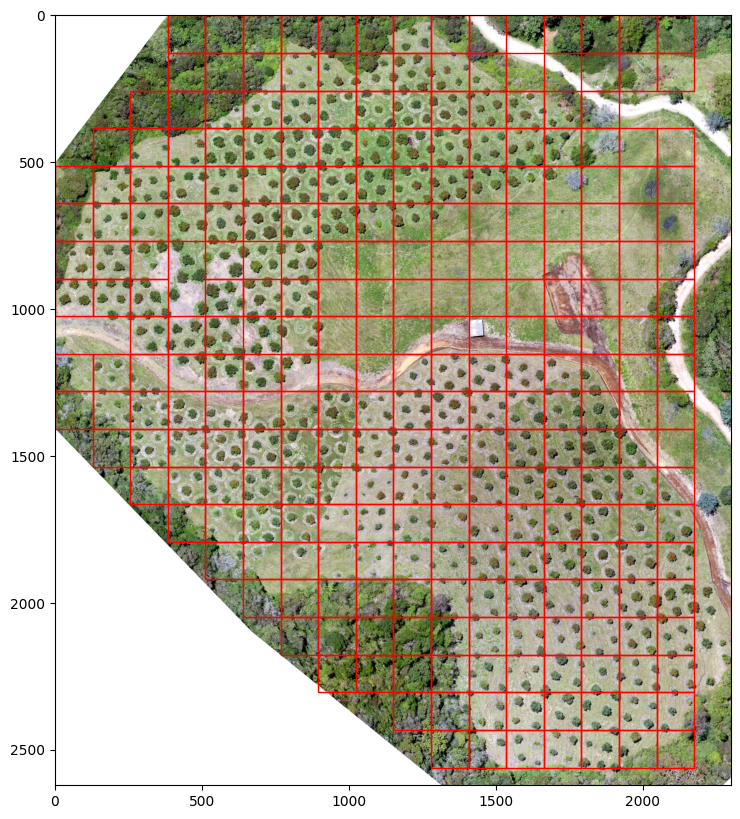

KeyboardInterrupt: Interrupted by user

In [17]:
    # --- Retraining Loop (ResNet or Sequential) ---
max_retraining_attempts = 10
for img_file in image_files: # Add this loop to define image within the scope
     retraining_attempts = 0
     while True: # Train and get feedback iteratively
            # Visualize and save initial predictions
            output_image = visualize_predictions(image, predictions, threshold=0.2)
            output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
            save_image(output_image, output_image_path)

            # Save predicted ROIs as GeoJSON
            predicted_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
            save_predicted_rois(predictions, img_path, predicted_geojson_path, threshold=0.1,image_crs = None)

            # --- Get Human Feedback ---
            corrected_polygons = get_human_feedback(img_path, predicted_geojson_path)

            # --- Update Labels with Human Feedback ---
            create_geojson_from_polygons(corrected_polygons, LABELS_PATH)

            # --- Ask for continuation ---
            continue_training = input("Continue training (y/n)? ")
            if continue_training.lower() != 'y':
                break  # Exit the training loop
            else:
             retraining_attempts += 1
             print("No best model found. Retrying then exiting.")
             break #Exit the loop

    # --- Prediction on All Unseen Images (using final best model) ---
     if best_model_path is not None:
        print(f"Loading best model from: {best_model_path}")
        interpreter = tf.lite.Interpreter(model_path=best_model_path)
        interpreter.allocate_tensors()

        for img_file in image_files:
         print(f"Analyzing: {img_file}")
         img_path = os.path.join(IMAGES_DIR, img_file)

        # Load and preprocess image
        with rasterio.open(img_path) as src:
            height = src.height
            width = src.width
            profile = src.profile  # Get rasterio profile for saving
            image = src.read()
            image = np.moveaxis(image, 0, -1)
            image = image.astype(np.float32)
            image_crs = src.crs

        # Predict on patches
        predictions = classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE)

        # --- DEBUGGING OUTPUTS ---
        # 1. Save predictions to a text file:
        with open(os.path.join(OUTPUT_DIR, f"predictions_{img_file[:-4]}.txt"), "w") as f:
            for (x, y), pred in predictions:
                f.write(f"Patch at ({x}, {y}): Prediction = {pred:.4f}\n")

        # 2. Visualize patches with high and low predictions:
        for (x, y), pred in predictions:
            if pred > 0.7:
                patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                cv2.imwrite(os.path.join(OUTPUT_DIR, f"high_pred_patch_{y}_{x}.png"), patch * 255.0)
            if pred < 0.3:
                patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                cv2.imwrite(os.path.join(OUTPUT_DIR, f"low_pred_patch_{y}_{x}.png"), patch * 255.0)

        # 3. Print summary statistics of predictions:
        preds_array = np.array([pred for (_, _), pred in predictions])
        print(f"Prediction Statistics (Mean: {preds_array.mean():.4f}, "
              f"Std: {preds_array.std():.4f}, Max: {preds_array.max():.4f})")
        # --- END OF DEBUGGING OUTPUTS ---

       # Visualize and save image
        output_image = visualize_predictions(image, predictions, threshold=0.2)
        output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
        save_image(output_image, output_image_path)

        # Save predicted ROIs as GeoJSON
        output_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
        # Pass image_crs to save_predicted_rois
        save_predicted_rois(predictions, img_path, output_geojson_path, threshold=0.1, image_crs=image_crs)

     else:
        print(f"No best model found for {img_file} after {max_retraining_attempts} attempts. Skipping.")

# CODIGOS Y EJECUCIONES PREVIAS DE ESTA CELDA EN ADELANTE

In [ ]:
if __name__ == "__main__":
    image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
    if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
    first_image_path = os.path.join(DATA_PATH, image_files[0])
    if not os.path.exists(LABELS_PATH):
        annotate_image(first_image_path, LABELS_PATH)

    # --- Parameter Grid for Exploration ---
    param_grid = {
        'patch_size': [(32, 32)],  # Start with a single patch size
        'batch_size': [1],  # Start with a single batch size
        'epochs': [5],  # Start with a small number of epochs
    }

    best_accuracy = 0.0
    best_model_path = None
    # Alternative training function
    train_files, val_files = train_test_split(image_files, test_size=VALIDATION_SPLIT, random_state=42)

    # --- Annotate the First Training Image (if needed) ---
    first_image_path = os.path.join(DATA_PATH, train_files[0])
    if not os.path.exists(LABELS_PATH):
        annotate_image(first_image_path, LABELS_PATH)

    # --- Parameter Grid for Exploration ---
    param_grid = {
        'patch_size': [(32, 32)],
        'batch_size': [1],
        'epochs': [5],
    }

    best_accuracy = 0.0
    best_model_path = None

    # --- Training Loop (Choose ResNet or Sequential) ---
    for model_type in ["resnet", "sequential"]:
        print(f"Training {model_type} model...")
        for params in ParameterGrid(param_grid):
            print(f"Training with parameters: {params}")
            patch_size = params['patch_size']
            batch_size = params['batch_size']
            epochs = params['epochs']

            # --- Load Training and Validation Data ---
            train_images, train_labels = [], []
            for train_file in train_files:
                image_path = os.path.join(IMAGES_DIR, train_file)
                images, labels = load_image_data(image_path, LABELS_PATH, patch_size=patch_size, use_pretrained=(model_type == "resnet"))
                train_images.extend(images)
                train_labels.extend(labels)
            train_images = np.array(train_images)
            train_labels = np.array(train_labels)

            val_images, val_labels = [], []
            for val_file in val_files:
                image_path = os.path.join(IMAGES_DIR, val_file)
                images, labels = load_image_data(image_path, LABELS_PATH, patch_size=patch_size, use_pretrained=(model_type == "resnet"))
                val_images.extend(images)
                val_labels.extend(labels)
            val_images = np.array(val_images)
            val_labels = np.array(val_labels)

            # Get input shape from training data
            input_shape = train_images[0].shape

            # Train model with data augmentation
            model, val_accuracy = train_model(
                input_shape, train_images, train_labels, val_images, val_labels, epochs, batch_size, use_pretrained=(model_type == "resnet")
            )

            # --- Convert to TensorFlow Lite ---
            converter = tf.lite.TFLiteConverter.from_keras_model(model)
            tflite_model = converter.convert()

            # --- Save TensorFlow Lite Model ---
            tflite_model_filename = f"{model_type}_model_patch{patch_size[0]}_batch{batch_size}_epochs{epochs}.tflite"
            tflite_model_path = os.path.join(OUTPUT_DIR, tflite_model_filename)
            with open(tflite_model_path, 'wb') as f:
                f.write(tflite_model)
            print(f"TFLite model saved to: {tflite_model_path}")

            # --- Update Best Model ---
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model_path = tflite_model_path


            history = model.fit(
             train_images, train_labels,
             epochs=10,
             batch_size=32,
             validation_data=(val_images, val_labels)
            )

            acc = history.history['accuracy']
            val_acc = history.history['val_accuracy']
            loss = history.history['loss']
            val_loss = history.history['val_loss']

            epochs_range = range(20)

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, acc, label='Precisión del Entrenamiento')
            plt.plot(epochs_range, val_acc, label='Precisión de la Validación')
            plt.legend(loc='lower right')
            plt.title('Precisión, Entrenamiento y Validación')

            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, loss, label='Pérdida en Entrenamiento')
            plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
            plt.legend(loc='upper right')
            plt.title('Pérdidas, Entrenamiento y Validación')

            plt.show()

Training resnet model...
Training with parameters: {'batch_size': 1, 'epochs': 5, 'patch_size': (32, 32)}


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1274/331398 ━━━━━━━━━━━━━━━━━━━━ 31:22:13 342ms/step - accuracy: 0.9287 - loss: 0.6021

KeyboardInterrupt: 

In [ ]:
# -*- coding: utf-8 -*-
"""
@author: public work
"""

IMG_HEIGHT = 32  # Reduced patch size
IMG_WIDTH = 32   # Reduced patch size
BATCH_SIZE = 1  # Decreased batch size
EPOCHS = 5     # Reduced epochs for faster testing
USE_PRETRAINED = True  # Set to True to use ResNet50
PATCH_SIZE = (IMG_HEIGHT, IMG_WIDTH)  # Match input size for pretrained model
VALIDATION_SPLIT = 0.2  # Proportion of data for validation

# Utility functions
def get_local_file_uri(file_path):
    file_path = os.path.abspath(file_path)
    return urlparse(f"file://{file_path}").geturl()

def create_geojson_from_polygons(polygons, output_path, crs="EPSG:4326"):
    gdf = gpd.GeoDataFrame({'geometry': [Polygon(poly) for poly in polygons]})
    gdf.crs = crs
    gdf.to_file(output_path, driver="GeoJSON")

def annotate_image(image_path, output_geojson_path):
    with rasterio.open(image_path) as src:
        # Calculate width and height of the quarter section
        width = src.width // 2
        height = src.height // 2

        # Read the lower-left quarter, handling different channel counts
        window = Window(0, src.height - height, width, height)
        if src.count == 1:
            img_data = src.read(1, window=window)  # Read single band
            img_data = np.expand_dims(img_data, axis=2)  # Add channel dimension
        else:
            img_data = src.read([1, 2, 3], window=window)
            img_data = np.moveaxis(img_data, 0, -1)

        # Convert to 8-bit for OpenCV compatibility
        img_data = (img_data * 255.0 / img_data.max()).astype(np.uint8)

        # Create a compatible OpenCV image (ensure contiguous data)
        img = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)

    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    print(f"Annotating: {image_path} (Lower-left quarter)")

    cv2.namedWindow("Image Annotation", cv2.WINDOW_NORMAL)
    polygons = []
    current_polygon = []

    def on_mouse(event, x, y, flags, param):
        nonlocal current_polygon, polygons
        if event == cv2.EVENT_LBUTTONDOWN:
            # Adjust coordinates to full image scale
            current_polygon.append([x + width, y + height])
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(current_polygon) > 2:
                polygons.append(current_polygon.copy())
                current_polygon = []
                # Adjust coordinates for drawing on the quarter image
                cv2.polylines(img, [np.array([[pt[0] - width, pt[1] - height] for pt in polygons[-1]], np.int32)],
                              True, (0, 255, 0), 2)
                cv2.imshow("Image Annotation", img)

    cv2.setMouseCallback("Image Annotation", on_mouse)

    print("Instructions:")
    print("- Left-click to add points to the polygon.")
    print("- Right-click to complete the current polygon.")
    print("- Press 'q' to finish annotation and save the GeoJSON.")

    while True:
        cv2.imshow("Image Annotation", img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    create_geojson_from_polygons(polygons, output_geojson_path)

# --- Data Loading and Preprocessing (Modified to Load One Image at a Time) ---
def load_image_data(image_path, labels_path, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED):
    """Loads data for a single image."""
    images = []
    labels = []

    # Read GeoJSON once
    gdf = gpd.read_file(labels_path)
    polygons = gdf.geometry.to_list()

    # Open image with rasterio
    with rasterio.open(image_path) as src:
        for y in range(0, src.height - patch_size[1] + 1, patch_size[1]):
            for x in range(0, src.width - patch_size[0] + 1, patch_size[0]):
                window = Window(x, y, patch_size[0], patch_size[1])
                image = src.read(window=window)
                image = np.moveaxis(image, 0, -1)
                image = image.astype(np.float32)

                # Handle 4-channel images
                if image.shape[-1] == 4:
                    image = image[:, :, :3]

                # Convert to 3 channels if using pretrained model
                if use_pretrained and image.shape[-1] != 3:
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                # Normalize data
                image = image / 255.0

                images.append(image)
                center_point = Point(x + patch_size[0] / 2, y + patch_size[1] / 2)
                label = 1 if any(polygon.contains(center_point) for polygon in polygons) else 0
                labels.append(label)

    return np.array(images), np.array(labels)

# --- Model Creation ---
def create_model(input_shape, num_classes=1, use_pretrained=USE_PRETRAINED, trainable_layers=10 ):
    if use_pretrained:
        # Ensure input_shape has 3 channels
        if input_shape[-1] != 3:
            input_shape = (*input_shape[:-1], 3)
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = True

        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for pretrained branch

    else:
        model = Sequential()
        # Correct input_shape for the first Conv2D layer (without batch dimension)
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())

        # Calculate Dense layer input size after Flatten - No need to build the model here
        dense_input_size = np.prod(model.output_shape[1:])
        model.add(Dense(dense_input_size // 2, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for non-pretrained branch

# --- Function to classify patches of an image using TensorFlow Lite ---
def classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE):
    height, width, _ = image.shape
    predictions = []

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_scale, input_zero_point = input_details[0]['quantization']

    for y in range(0, height - patch_size[1] + 1, patch_size[1]):
        for x in range(0, width - patch_size[0] + 1, patch_size[0]):
            patch = image[y:y + patch_size[1], x:x + patch_size[0]]
            patch = patch / 255.0  # Normalize patch
            patch = np.expand_dims(patch, axis=0).astype(np.float32) # Add batch dimension

            # Set tensor and invoke the interpreter
            interpreter.set_tensor(input_details[0]['index'], patch)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            prediction = output_data[0][0]

            # --- DEBUG: Save patch with prediction value ---
            patch_filename = f"patch_{y}_{x}_pred_{prediction:.2f}.png"
            patch_path = os.path.join(OUTPUT_DIR, patch_filename)
            cv2.imwrite(patch_path, patch * 255.0)

            predictions.append(((x, y), prediction))

    return predictions

# --- Model Training Function ---
def train_model(input_shape, images, labels, epochs, batch_size, use_pretrained=USE_PRETRAINED, validation_split=VALIDATION_SPLIT):
    # Split data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=validation_split, random_state=42
    )

    model = create_model(input_shape, use_pretrained=use_pretrained)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

    # Evaluate the model on the validation set
    _, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, val_accuracy  # Return both the model and val_accuracy

# --- Training ---
if __name__ == "__main__":
    image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
    if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
    first_image_path = os.path.join(DATA_PATH, image_files[0])
    if not os.path.exists(LABELS_PATH):
        annotate_image(first_image_path, LABELS_PATH)

    # --- Parameter Grid for Exploration ---
    param_grid = {
        'patch_size': [(32, 32)],  # Start with a single patch size
        'batch_size': [1],  # Start with a single batch size
        'epochs': [5],  # Start with a small number of epochs
    }

    best_accuracy = 0.0
    best_model_path = None

    # --- Training Loop (Choose ResNet or Sequential) ---
    for model_type in ["resnet", "sequential"]:
        print(f"Training {model_type} model...")
        for params in ParameterGrid(param_grid):
            print(f"Training with parameters: {params}")
            patch_size = params['patch_size']
            batch_size = params['batch_size']
            epochs = params['epochs']

            # --- Load and Train on One Image at a Time ---
            for image_file in image_files:
                image_path = os.path.join(IMAGES_DIR, image_file)

                # Load data for a single image
                images, labels = load_image_data(
                    image_path, LABELS_PATH, patch_size=patch_size, use_pretrained=(model_type == "resnet")
                )
                input_shape = images[0].shape

                model, val_accuracy = train_model(
                    input_shape, images, labels, epochs, batch_size, use_pretrained=(model_type == "resnet")
                )

                # --- Convert to TensorFlow Lite ---
                converter = tf.lite.TFLiteConverter.from_keras_model(model)
                tflite_model = converter.convert()

                # --- Save TensorFlow Lite Model ---
                tflite_model_filename = f"{model_type}_model_patch{patch_size[0]}_batch{batch_size}_epochs{epochs}_{image_file[:-4]}.tflite"
                tflite_model_path = os.path.join(OUTPUT_DIR, tflite_model_filename)
                with open(tflite_model_path, 'wb') as f:
                    f.write(tflite_model)
                print(f"TFLite model saved to: {tflite_model_path}")

                # --- Update Best Model (Based on Last Image) ---
                # (Consider a more robust method for best model selection)
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model_path = tflite_model_path

    # --- Prediction on Unseen Images (using best TFLite model) ---
    if best_model_path is not None:
        print(f"Loading best model from: {best_model_path}")
        interpreter = tf.lite.Interpreter(model_path=best_model_path)
        interpreter.allocate_tensors()

        for img_file in image_files:
            print(f"Analyzing: {img_file}")
            img_path = os.path.join(IMAGES_DIR, img_file)

            # Load and preprocess image
            with rasterio.open(img_path) as src:
                height = src.height
                width = src.width
                profile = src.profile  # Get rasterio profile for saving
                image = src.read()
                image = np.moveaxis(image, 0, -1)
                image = image.astype(np.float32)

            # Predict on patches
            predictions = classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE)

            # --- DEBUGGING OUTPUTS ---
            # 1. Save predictions to a text file:
            with open(os.path.join(OUTPUT_DIR, f"predictions_{img_file[:-4]}.txt"), "w") as f:
                for (x, y), pred in predictions:
                    f.write(f"Patch at ({x}, {y}): Prediction = {pred:.4f}\n")

            # 2. Visualize patches with high and low predictions:
            for (x, y), pred in predictions:
                if pred > 0.7:
                    patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                    cv2.imwrite(os.path.join(OUTPUT_DIR, f"high_pred_patch_{y}_{x}.png"), patch * 255.0)
                if pred < 0.3:
                    patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                    cv2.imwrite(os.path.join(OUTPUT_DIR, f"low_pred_patch_{y}_{x}.png"), patch * 255.0)

            # 3. Print summary statistics of predictions:
            preds_array = np.array([pred for (_, _), pred in predictions])
            print(f"Prediction Statistics (Mean: {preds_array.mean():.4f}, "
                  f"Std: {preds_array.std():.4f}, Max: {preds_array.max():.4f})")
            # --- END OF DEBUGGING OUTPUTS ---

            # Visualize and save image
            output_image = visualize_predictions(image, predictions, threshold=0.2)
            output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
            save_image(output_image, output_image_path)

            # Save predicted ROIs as GeoJSON
            output_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
            save_predicted_rois(predictions, img_path, output_geojson_path, threshold=0.1)

In [ ]:
param_grid = {
    'patch_size': [(32, 32)],
    'batch_size': [1],
    'epochs': [5],
}

best_accuracy = 0.0
best_model_path = None

# --- Training Loop (Choose ResNet or Sequential) ---
for model_type in ["resnet", "sequential"]:
    print(f"Training {model_type} model...")
    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        patch_size = params['patch_size']
        batch_size = params['batch_size']
        epochs = params['epochs']

        images, labels = load_image_data(DATA_PATH, LABELS_PATH, patch_size=patch_size,
                                   use_pretrained=(model_type == "resnet"))
        input_shape = images[0].shape

        model, val_accuracy = train_model(
            input_shape, images, labels, epochs, batch_size, use_pretrained=(model_type == "resnet")
        )

        # --- Convert to TensorFlow Lite ---
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()

        # --- Save TensorFlow Lite Model ---
        tflite_model_filename = f"{model_type}_model_patch{patch_size[0]}_batch{batch_size}_epochs{epochs}.tflite"
        tflite_model_path = os.path.join(OUTPUT_DIR, tflite_model_filename)
        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model)
        print(f"TFLite model saved to: {tflite_model_path}")

        # --- Update Best Model ---
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_path = tflite_model_path

Training resnet model...
Training with parameters: {'batch_size': 1, 'epochs': 5, 'patch_size': (32, 32)}


RasterioIOError: '/content/drive/My Drive/Colab Notebooks/' not recognized as being in a supported file format.

In [ ]:
if not os.path.exists(LABELS_PATH):
    image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
    if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
    first_image_path = os.path.join(DATA_PATH, image_files[0])
    annotate_image(first_image_path, LABELS_PATH)

In [ ]:
if best_model_path is not None:
    print(f"Loading best model from: {best_model_path}")
    interpreter = tf.lite.Interpreter(model_path=best_model_path)
    interpreter.allocate_tensors()

    for img_file in image_files:
        print(f"Analyzing: {img_file}")
        img_path = os.path.join(IMAGES_DIR, img_file)

        # Load and preprocess image
        with rasterio.open(img_path) as src:
            height = src.height
            width = src.width
            profile = src.profile
            image = src.read()
            image = np.moveaxis(image, 0, -1)
            image = image.astype(np.float32)

        # Predict on patches
        predictions = classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE)

        # --- DEBUGGING OUTPUTS ---
            # 1. Save predictions to a text file:
            with open(os.path.join(OUTPUT_DIR, f"predictions_{img_file[:-4]}.txt"), "w") as f:
                for (x, y), pred in predictions:
                    f.write(f"Patch at ({x}, {y}): Prediction = {pred:.4f}\n")

            # 2. Visualize patches with high and low predictions:
            for (x, y), pred in predictions:
                if pred > 0.7:
                    patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                    cv2.imwrite(os.path.join(OUTPUT_DIR, f"high_pred_patch_{y}_{x}.png"), patch * 255.0)
                if pred < 0.3:
                    patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                    cv2.imwrite(os.path.join(OUTPUT_DIR, f"low_pred_patch_{y}_{x}.png"), patch * 255.0)

            # 3. Print summary statistics of predictions:
            preds_array = np.array([pred for (_, _), pred in predictions])
            print(f"Prediction Statistics (Mean: {preds_array.mean():.4f}, "
                  f"Std: {preds_array.std():.4f}, Max: {preds_array.max():.4f})")
            # --- END OF DEBUGGING OUTPUTS ---

        # Visualize and save image
        output_image = visualize_predictions(image, predictions, threshold=0.2)
        output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
        save_image(output_image, output_image_path)

        # Save predicted ROIs as GeoJSON
        output_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
        save_predicted_rois(predictions, img_path, output_geojson_path, threshold=0.1)

In [ ]:
!pip install shapely --upgrade --no-binary shapely

In [ ]:
# -*- coding: utf-8 -*-
"""
@author: public work
"""

IMG_HEIGHT = 32  # Reduced patch size
IMG_WIDTH = 32   # Reduced patch size
BATCH_SIZE = 1  # Decreased batch size
EPOCHS = 5     # Reduced epochs for faster testing
USE_PRETRAINED = True  # Set to True to use ResNet50
PATCH_SIZE = (IMG_HEIGHT, IMG_WIDTH)  # Match input size for pretrained model
VALIDATION_SPLIT = 0.2  # Proportion of data for validation

# Utility functions
def get_local_file_uri(file_path):
    file_path = os.path.abspath(file_path)
    return urlparse(f"file://{file_path}").geturl()

def create_geojson_from_polygons(polygons, output_path, crs="EPSG:4326"):
    gdf = gpd.GeoDataFrame({'geometry': [Polygon(poly) for poly in polygons]})
    gdf.crs = crs
    gdf.to_file(output_path, driver="GeoJSON")

def annotate_image(image_path, output_geojson_path):
    with rasterio.open(image_path) as src:
        # Calculate width and height of the quarter section
        width = src.width // 2
        height = src.height // 2

        # Read the lower-left quarter, handling different channel counts
        window = Window(0, src.height - height, width, height)
        if src.count == 1:
            img_data = src.read(1, window=window)  # Read single band
            img_data = np.expand_dims(img_data, axis=2)  # Add channel dimension
        else:
            img_data = src.read([1, 2, 3], window=window)
            img_data = np.moveaxis(img_data, 0, -1)

        # Convert to 8-bit for OpenCV compatibility
        img_data = (img_data * 255.0 / img_data.max()).astype(np.uint8)

        # Create a compatible OpenCV image (ensure contiguous data)
        img = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)

    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    print(f"Annotating: {image_path} (Lower-left quarter)")

    cv2.namedWindow("Image Annotation", cv2.WINDOW_NORMAL)
    polygons = []
    current_polygon = []

    def on_mouse(event, x, y, flags, param):
        nonlocal current_polygon, polygons
        if event == cv2.EVENT_LBUTTONDOWN:
            # Adjust coordinates to full image scale
            current_polygon.append([x + width, y + height])
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(current_polygon) > 2:
                polygons.append(current_polygon.copy())
                current_polygon = []
                # Adjust coordinates for drawing on the quarter image
                cv2.polylines(img, [np.array([[pt[0] - width, pt[1] - height] for pt in polygons[-1]], np.int32)],
                              True, (0, 255, 0), 2)
                cv2.imshow("Image Annotation", img)

    cv2.setMouseCallback("Image Annotation", on_mouse)

    print("Instructions:")
    print("- Left-click to add points to the polygon.")
    print("- Right-click to complete the current polygon.")
    print("- Press 'q' to finish annotation and save the GeoJSON.")

    while True:
        cv2.imshow("Image Annotation", img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    create_geojson_from_polygons(polygons, output_geojson_path)

# --- Data Loading and Preprocessing (Modified to Load One Image at a Time) ---
def load_image_data(image_path, labels_path, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED):
    """Loads data for a single image."""
    images = []
    labels = []

    # Read GeoJSON once
    gdf = gpd.read_file(labels_path)
    polygons = gdf.geometry.to_list()

    # Open image with rasterio
    with rasterio.open(image_path) as src:
        for y in range(0, src.height - patch_size[1] + 1, patch_size[1]):
            for x in range(0, src.width - patch_size[0] + 1, patch_size[0]):
                window = Window(x, y, patch_size[0], patch_size[1])
                image = src.read(window=window)
                image = np.moveaxis(image, 0, -1)
                image = image.astype(np.float32)

                # Handle 4-channel images
                if image.shape[-1] == 4:
                    image = image[:, :, :3]

                # Convert to 3 channels if using pretrained model
                if use_pretrained and image.shape[-1] != 3:
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                # Normalize data
                image = image / 255.0

                images.append(image)
                center_point = Point(x + patch_size[0] / 2, y + patch_size[1] / 2)
                label = 1 if any(polygon.contains(center_point) for polygon in polygons) else 0
                labels.append(label)

    return np.array(images), np.array(labels)

# --- Model Creation ---
def create_model(input_shape, num_classes=1, use_pretrained=USE_PRETRAINED, trainable_layers=10 ):
    if use_pretrained:
        # Ensure input_shape has 3 channels
        if input_shape[-1] != 3:
            input_shape = (*input_shape[:-1], 3)
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = True

        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for pretrained branch

    else:
        model = Sequential()
        # Correct input_shape for the first Conv2D layer (without batch dimension)
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())

        # Calculate Dense layer input size after Flatten - No need to build the model here
        dense_input_size = np.prod(model.output_shape[1:])
        model.add(Dense(dense_input_size // 2, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for non-pretrained branch

# --- Function to classify patches of an image using TensorFlow Lite ---
def classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE):
    height, width, _ = image.shape
    predictions = []

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_scale, input_zero_point = input_details[0]['quantization']

    for y in range(0, height - patch_size[1] + 1, patch_size[1]):
        for x in range(0, width - patch_size[0] + 1, patch_size[0]):
            patch = image[y:y + patch_size[1], x:x + patch_size[0]]
            patch = patch / 255.0  # Normalize patch
            patch = np.expand_dims(patch, axis=0).astype(np.float32) # Add batch dimension

            # Set tensor and invoke the interpreter
            interpreter.set_tensor(input_details[0]['index'], patch)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            prediction = output_data[0][0]

            # --- DEBUG: Save patch with prediction value ---
            patch_filename = f"patch_{y}_{x}_pred_{prediction:.2f}.png"
            patch_path = os.path.join(OUTPUT_DIR, patch_filename)
            cv2.imwrite(patch_path, patch * 255.0)

            predictions.append(((x, y), prediction))

    return predictions

# --- Model Training Function ---
def train_model(input_shape, images, labels, epochs, batch_size, use_pretrained=USE_PRETRAINED, validation_split=VALIDATION_SPLIT):
    # Split data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=validation_split, random_state=42
    )

    model = create_model(input_shape, use_pretrained=use_pretrained)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

    # Evaluate the model on the validation set
    _, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, val_accuracy  # Return both the model and val_accuracy

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 25 14:44:11 2024

@author: public work
"""

import os
import geopandas as gpd

import rasterio
from rasterio.windows import Window
import cv2
from shapely.geometry import *
from urllib.parse import urlparse
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split, ParameterGrid
from google.colab import files


AttributeError: partially initialized module 'shapely' has no attribute 'lib' (most likely due to a circular import)

In [ ]:

# --- Configuration ---
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/DronearthHass"
IMAGES_DIR = DATA_PATH
LABELS_PATH = os.path.join(DATA_PATH, "labels.geojson")
OUTPUT_DIR = "plant_detection_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_HEIGHT = 64  # Reduced patch size
IMG_WIDTH = 64   # Reduced patch size
BATCH_SIZE = 2  # Decreased batch size
EPOCHS = 10     # Increased epochs
USE_PRETRAINED = True  # Set to True to use ResNet50
PATCH_SIZE = (IMG_HEIGHT, IMG_WIDTH)  # Match input size for pretrained model
VALIDATION_SPLIT = 0.2  # Proportion of data for validation

# --- GPU Configuration (Google Colab) ---
# Google Colab provides GPU by default, so no need to check
# However, you might want to force a specific GPU if needed:
# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
# print("Using GPU for processing.")

# Utility functions
def get_local_file_uri(file_path):
    file_path = os.path.abspath(file_path)
    return urlparse(f"file://{file_path}").geturl()

def create_geojson_from_polygons(polygons, output_path, crs="EPSG:4326"):
    gdf = gpd.GeoDataFrame({'geometry': [Polygon(poly) for poly in polygons]})
    gdf.crs = crs
    gdf.to_file(output_path, driver="GeoJSON")

def annotate_image(image_path, output_geojson_path):
    with rasterio.open(image_path) as src:
        # Calculate width and height of the quarter section
        width = src.width // 2
        height = src.height // 2

        # Read the lower-left quarter, handling different channel counts
        window = Window(0, src.height - height, width, height)
        if src.count == 1:
            img_data = src.read(1, window=window)  # Read single band
            img_data = np.expand_dims(img_data, axis=2)  # Add channel dimension
        else:
            img_data = src.read([1, 2, 3], window=window)
            img_data = np.moveaxis(img_data, 0, -1)

        # Convert to 8-bit for OpenCV compatibility
        img_data = (img_data * 255.0 / img_data.max()).astype(np.uint8)

        # Create a compatible OpenCV image (ensure contiguous data)
        img = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)

    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    print(f"Annotating: {image_path} (Lower-left quarter)")

    cv2.namedWindow("Image Annotation", cv2.WINDOW_NORMAL)
    polygons = []
    current_polygon = []

    def on_mouse(event, x, y, flags, param):
        nonlocal current_polygon, polygons
        if event == cv2.EVENT_LBUTTONDOWN:
            # Adjust coordinates to full image scale
            current_polygon.append([x + width, y + height])
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(current_polygon) > 2:
                polygons.append(current_polygon.copy())
                current_polygon = []
                # Adjust coordinates for drawing on the quarter image
                cv2.polylines(img, [np.array([[pt[0] - width, pt[1] - height] for pt in polygons[-1]], np.int32)],
                              True, (0, 255, 0), 2)
                cv2.imshow("Image Annotation", img)

    cv2.setMouseCallback("Image Annotation", on_mouse)

    print("Instructions:")
    print("- Left-click to add points to the polygon.")
    print("- Right-click to complete the current polygon.")
    print("- Press 'q' to finish annotation and save the GeoJSON.")

    while True:
        cv2.imshow("Image Annotation", img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    create_geojson_from_polygons(polygons, output_geojson_path)

# --- Data Loading and Preprocessing (Optimized) ---
def load_data(images_dir, labels_path, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED, max_images=10):
    image_files = [
        f for f in os.listdir(images_dir)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ][:max_images]  # Limit the number of images

    images = []
    labels = []

    # Read GeoJSON file once
    gdf = gpd.read_file(labels_path)
    polygons = gdf.geometry.to_list()

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        with rasterio.open(image_path) as src:
            # Extract patches in batches to reduce memory usage
            for y in range(0, src.height - patch_size[1] + 1, patch_size[1]):
                for x in range(0, src.width - patch_size[0] + 1, patch_size[0]):
                    window = Window(x, y, patch_size[0], patch_size[1])
                    image = src.read(window=window)
                    image = np.moveaxis(image, 0, -1)
                    image = image.astype(np.float32)

                    # Handle 4-channel images (remove alpha channel)
                    if image.shape[-1] == 4:
                        image = image[:, :, :3]

                    # Convert to 3 channels if using pretrained model and patch is grayscale
                    if use_pretrained and image.shape[-1] == 1:
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                    # Normalize data
                    image = image / 255.0

                    images.append(image)
                    center_point = Point(x + patch_size[0] / 2, y + patch_size[1] / 2)
                    label = 1 if any(polygon.contains(center_point) for polygon in polygons) else 0
                    labels.append(label)

                # Process a batch of patches
                if len(images) >= BATCH_SIZE:
                    yield np.array(images), np.array(labels)
                    images = []  # Clear the batch
                    labels = []

# --- Model Creation ---
def create_model(input_shape, num_classes=1, use_pretrained=USE_PRETRAINED, trainable_layers=10):
    if use_pretrained:
        # Ensure input_shape has 3 channels
        if input_shape[-1] != 3:
            input_shape = (*input_shape[:-1], 3)
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = True

        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for pretrained branch

    else:
        model = Sequential()
        # Correct input_shape for the first Conv2D layer (without batch dimension)
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())

        # Calculate Dense layer input size after Flatten - No need to build the model here
        dense_input_size = np.prod(model.output_shape[1:])
        model.add(Dense(dense_input_size // 2, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for non-pretrained branch

def classify_patches(model, image, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED):  # Add use_pretrained argument
    height, width, channels = image.shape
    predictions = []

    for y in range(0, height - patch_size[1] + 1, patch_size[1]):
        for x in range(0, width - patch_size[0] + 1, patch_size[0]):
            patch = image[y:y + patch_size[1], x:x + patch_size[0]]

            # Handle 4-channel images (remove alpha channel)
            if patch.shape[-1] == 4:
                patch = patch[:, :, :3]

            # Convert to 3 channels if using pretrained model and patch is grayscale
            if use_pretrained and patch.shape[-1] != 3:
                patch = cv2.cvtColor(patch, cv2.COLOR_GRAY2RGB)

            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch)

            # Save patch with prediction for debugging
            patch_filename = f"patch_{y}_{x}_pred_{prediction[0][0]:.2f}.png"
            patch_path = os.path.join(OUTPUT_DIR, patch_filename)
            cv2.imwrite(patch_path, patch * 255.0)

            predictions.append(((x, y), prediction[0][0]))

    return predictions

def visualize_predictions(image, predictions, threshold=0.5): # Adjust threshold
    output_image = image.copy() # Create a copy to draw on
    for (x, y), prediction in predictions:
        if prediction >= threshold:
            # Correct rectangle coordinates for visualization
            cv2.rectangle(output_image, (x, y), (x + PATCH_SIZE[0], y + PATCH_SIZE[1]), (0, 255, 0), 2)
    return output_image

# --- Function to save predicted ROIs as GeoJSON ---
def save_predicted_rois(predictions, image_path, output_geojson_path, threshold=0.5):
    with rasterio.open(image_path) as src:
        transform = src.transform
    predicted_polygons = []
    for (x, y), prediction in predictions:
        if prediction >= threshold:
            polygon = box(x, y, x + PATCH_SIZE[0], y + PATCH_SIZE[1])
            # Transform polygon to image coordinates
            polygon = transform * polygon
            predicted_polygons.append(polygon)

    create_geojson_from_polygons(predicted_polygons, output_geojson_path)

# --- Model Training Function ---
def train_model(input_shape, images, labels, epochs, batch_size, use_pretrained=USE_PRETRAINED, validation_split=VALIDATION_SPLIT):
    # Split data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=validation_split, random_state=42
    )

    model = create_model(input_shape, use_pretrained=use_pretrained)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

    # Evaluate the model on the validation set
    _, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, val_accuracy

# --- Enhanced save_image Function ---
def save_image(image, output_path):
    # Try saving as TIFF using rasterio
    try:
        with rasterio.open(output_path[:-4] + ".tif", 'w', **profile) as dst:
            dst.write(np.moveaxis(image, -1, 0))  # Reorder channels for rasterio
        print(f"Image saved as: {output_path[:-4]}.tif")
        return

    except Exception as e:
        print(f"Error saving as TIFF: {e}")

    # Try saving as PNG using OpenCV
    try:
        cv2.imwrite(output_path[:-4] + ".png", image)
        print(f"Image saved as: {output_path[:-4]}.png")
        return

    except Exception as e:
        print(f"Error saving as PNG: {e}")

    # Try saving as JPG using OpenCV
    try:
        cv2.imwrite(output_path[:-4] + ".jpg", image)
        print(f"Image saved as: {output_path[:-4]}.jpg")
        return

    except Exception as e:
        print(f"Error saving as JPG: {e}")

    print(f"Could not save image to any format: {output_path}")

# --- Training ---
if __name__ == "__main__":
    image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
    if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
    first_image_path = os.path.join(DATA_PATH, image_files[0])
    if not os.path.exists(LABELS_PATH):
        annotate_image(first_image_path, LABELS_PATH)

    # --- Load Pretrained Model if Available ---
    model_path_h5 = os.path.join(OUTPUT_DIR, 'plant_detection_model.h5')
    model_path_keras = os.path.join(OUTPUT_DIR, 'plant_detection_model.keras')

    if os.path.exists(model_path_h5):
        print("Loading pretrained model from:", model_path_h5)
        model = keras.models.load_model(model_path_h5)
    elif os.path.exists(model_path_keras):
        print("Loading pretrained model from:", model_path_keras)
        model = keras.models.load_model(model_path_keras)
    else:
        # --- Load Data in Batches (Handle Generator) ---
        images, labels = [], []
        for batch_images, batch_labels in load_data(DATA_PATH, LABELS_PATH, max_images=10): # Load in batches
            images.extend(batch_images)
            labels.extend(batch_labels)

        images = np.array(images)
        labels = np.array(labels)
        input_shape = images[0].shape

        model = create_model(input_shape, use_pretrained=USE_PRETRAINED)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(images, labels, epochs=EPOCHS, batch_size=BATCH_SIZE)
        # --- Save the Model ---
        model.save(os.path.join(OUTPUT_DIR, 'plant_detection_model.h5'))
        model.save(os.path.join(OUTPUT_DIR, 'plant_detection_model.keras'))
        print("Model saved to:", os.path.join(OUTPUT_DIR, 'plant_detection_model.h5'))

    # --- Prediction on Unseen Images ---
    for img_file in image_files:
        print(f"Analyzing: {img_file}")
        img_path = os.path.join(IMAGES_DIR, img_file)

        # Load and preprocess image
        with rasterio.open(img_path) as src:
            height = src.height
            width = src.width
            profile = src.profile  # Get rasterio profile for saving
            image = src.read()
            image = np.moveaxis(image, 0, -1)
            image = image.astype(np.float32)

        # Predict on patches (no channel conversion here)
        predictions = classify_patches(model, image, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED)

        # Visualize and save
        output_image = visualize_predictions(image, predictions, threshold=0.2)  # Adjusted threshold
        output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
        save_image(output_image, output_image_path)  # Use enhanced save_image function

        # Save predicted ROIs as GeoJSON
        output_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
        save_predicted_rois(predictions, img_path, output_geojson_path, threshold=0.1)  # Adjusted threshold

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 752s 28ms/step - accuracy: 0.9098 - loss: 0.3490
Epoch 2/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 677s 28ms/step - accuracy: 0.9100 - loss: 0.3132
Epoch 3/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 673s 28ms/step - accuracy: 0.9105 - loss: 0.3051
Epoch 4/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 668s 28ms/step - accuracy: 0.9084 - loss: 0.2881
Epoch 5/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 668s 28ms/step - accuracy: 0.9086 - loss: 0.2543
Epoch 6/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 680s 27ms/step - accuracy: 0.9093 - loss: 0.2362
Epoch 7/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 686s 28ms/step - accuracy: 0.9100 - loss: 0.2241
Epoch 8/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 702s 28ms/step - accuracy: 0.9090 - loss: 0.2209
Epoch 9/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 748s 29ms/step - accuracy: 0.9078 - loss: 0.2244
Epoch 10/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 750s 29ms/step - accuracy: 0.9082 - loss: 0.2155


Model saved to: plant_detection_output/plant_detection_model.h5
Analyzing: fJI_0012.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/

Ejecucion 1>
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

**ERROR Out of memory**


Ejecucion 2>

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
15223/24225 ━━━━━━━━━━━━━━━━━━━━ 1:22:00 547ms/step - accuracy: 0.9094 - loss: 0.3563

Detenido por el usuario, cambio de recursos del colab a T4 GPU


Ejecucion 3> /usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 752s 28ms/step - accuracy: 0.9098 - loss: 0.3490
Epoch 2/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 677s 28ms/step - accuracy: 0.9100 - loss: 0.3132
Epoch 3/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 673s 28ms/step - accuracy: 0.9105 - loss: 0.3051
Epoch 4/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 668s 28ms/step - accuracy: 0.9084 - loss: 0.2881
Epoch 5/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 668s 28ms/step - accuracy: 0.9086 - loss: 0.2543
Epoch 6/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 680s 27ms/step - accuracy: 0.9093 - loss: 0.2362
Epoch 7/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 686s 28ms/step - accuracy: 0.9100 - loss: 0.2241
Epoch 8/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 702s 28ms/step - accuracy: 0.9090 - loss: 0.2209
Epoch 9/10
24225/24225 ━━━━━━━━━━━━━━━━━━━━ 748s 29ms/step - accuracy: 0.9078 - loss: 0.2244
Epoch 10/10
 3551/24225 ━━━━━━━━━━━━━━━━━━━━ 9:59 29ms/step - accuracy: 0.9052 - loss: 0.2206

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu september 12 11:44:11 2024

@author: public work
"""
import os
import geopandas as gpd
import rasterio
from rasterio.windows import Window
import cv2
from shapely.geometry import *
from urllib.parse import urlparse
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split, ParameterGrid
from google.colab import files # for uploading files
from google.colab import drive # for mounting drive
#from google.cloud import aiplatform  # Import the Gemini API library - Uncomment if you have an API key and have setup the API access

# --- Configuration ---
# Replace with your Google Drive mount point
DATA_PATH = "/content/drive/My Drive/Colab Notebooks"
IMAGES_DIR = DATA_PATH
LABELS_PATH = os.path.join(DATA_PATH, "labels.geojson")
OUTPUT_DIR = "plant_detection_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_HEIGHT = 32  # Reduced patch size
IMG_WIDTH = 32   # Reduced patch size
BATCH_SIZE = 1  # Decreased batch size
EPOCHS = 5     # Increased epochs
USE_PRETRAINED = True  # Set to True to use ResNet50
PATCH_SIZE = (IMG_HEIGHT, IMG_WIDTH)  # Match input size for pretrained model
VALIDATION_SPLIT = 0.2  # Proportion of data for validation

# --- GPU Configuration (Google Colab) ---
# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
# print("Using GPU for processing.")

# --- Gemini Configuration ---
# Replace with Gemini endpoint
# ENDPOINT_NAME = "projects/project-id/locations/us-central1/endpoints/endpoint-id"

# Utility functions
def get_local_file_uri(file_path):
    file_path = os.path.abspath(file_path)
    return urlparse(f"file://{file_path}").geturl()

def create_geojson_from_polygons(polygons, output_path, crs="EPSG:4326"):
    gdf = gpd.GeoDataFrame({'geometry': [Polygon(poly) for poly in polygons]})
    gdf.crs = crs
    gdf.to_file(output_path, driver="GeoJSON")

def annotate_image(image_path, output_geojson_path):
    with rasterio.open(image_path) as src:
        # Calculate width and height of the quarter section
        width = src.width // 2
        height = src.height // 2

        # Read the lower-left quarter, handling different channel counts
        window = Window(0, src.height - height, width, height)
        if src.count == 1:
            img_data = src.read(1, window=window)  # Read single band
            img_data = np.expand_dims(img_data, axis=2)  # Add channel dimension
        else:
            img_data = src.read([1, 2, 3], window=window)
            img_data = np.moveaxis(img_data, 0, -1)

        # Convert to 8-bit for OpenCV compatibility
        img_data = (img_data * 255.0 / img_data.max()).astype(np.uint8)

        # Create a compatible OpenCV image (ensure contiguous data)
        img = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)

    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    print(f"Annotating: {image_path} (Lower-left quarter)")

    cv2.namedWindow("Image Annotation", cv2.WINDOW_NORMAL)
    polygons = []
    current_polygon = []

    def on_mouse(event, x, y, flags, param):
        nonlocal current_polygon, polygons
        if event == cv2.EVENT_LBUTTONDOWN:
            # Adjust coordinates to full image scale
            current_polygon.append([x + width, y + height])
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(current_polygon) > 2:
                polygons.append(current_polygon.copy())
                current_polygon = []
                # Adjust coordinates for drawing on the quarter image
                cv2.polylines(img, [np.array([[pt[0] - width, pt[1] - height] for pt in polygons[-1]], np.int32)],
                              True, (0, 255, 0), 2)
                cv2.imshow("Image Annotation", img)

    cv2.setMouseCallback("Image Annotation", on_mouse)

    print("Instructions:")
    print("- Left-click to add points to the polygon.")
    print("- Right-click to complete the current polygon.")
    print("- Press 'q' to finish annotation and save the GeoJSON.")

    while True:
        cv2.imshow("Image Annotation", img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    create_geojson_from_polygons(polygons, output_geojson_path)

# --- Data Loading and Preprocessing ---
def load_data(images_dir, labels_path, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED):
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))]
    images = []
    labels = []

    # Read GeoJSON once
    gdf = gpd.read_file(labels_path)
    polygons = gdf.geometry.to_list()

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)

        # Open image with rasterio
        with rasterio.open(image_path) as src:
            for y in range(0, src.height - patch_size[1] + 1, patch_size[1]):
                for x in range(0, src.width - patch_size[0] + 1, patch_size[0]):
                    window = Window(x, y, patch_size[0], patch_size[1])
                    image = src.read(window=window)
                    image = np.moveaxis(image, 0, -1)
                    image = image.astype(np.float32)


                    # Handle 4-channel images (remove alpha channel)
                    if image.shape[-1] == 4:
                        image = image[:,:,:3]

                    # Convert to 3 channels if using pretrained model (ResNet expects 3 channels)
                    if use_pretrained and image.shape[-1] != 3:
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                    # Normalize data
                    image = image / 255.0

                    images.append(image)
                    center_point = Point(x + patch_size[0] / 2, y + patch_size[1] / 2)
                    label = 1 if any(polygon.contains(center_point) for polygon in polygons) else 0
                    labels.append(label)

    return np.array(images), np.array(labels)

# --- Model Creation ---
def create_model(input_shape, num_classes=1, use_pretrained=USE_PRETRAINED, trainable_layers=10 ):
    if use_pretrained:
        # Ensure input_shape has 3 channels
        if input_shape[-1] != 3:
            input_shape = (*input_shape[:-1], 3)
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = True

        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for pretrained branch

    else:
        model = Sequential()
        # Correct input_shape for the first Conv2D layer (without batch dimension)
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())

        # Calculate Dense layer input size after Flatten - No need to build the model here
        dense_input_size = np.prod(model.output_shape[1:])
        model.add(Dense(dense_input_size // 2, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for non-pretrained branch

# --- Gemini API Call (Optional) ---
#    aiplatform_client = aiplatform.gapic.PredictionServiceClient()  # Initialize the client
#    response = aiplatform_client.predict(
#        endpoint=ENDPOINT_NAME,
#        instances=[{"content": prompt}],
#        parameters={"temperature": 0.7}  # Adjust temperature as needed
#    )
#    return response.predictions[0]["content"]

def classify_patches(model, image, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED):  # Add use_pretrained argument
    height, width, channels = image.shape
    predictions = []

    for y in range(0, height - patch_size[1] + 1, patch_size[1]):
        for x in range(0, width - patch_size[0] + 1, patch_size[0]):
            patch = image[y:y + patch_size[1], x:x + patch_size[0]]

            # Handle 4-channel images (remove alpha channel)
            if patch.shape[-1] == 4:
                patch = patch[:, :, :3]

            # Convert to 3 channels if using pretrained model and patch is grayscale
            if use_pretrained and patch.shape[-1] != 3:
                patch = cv2.cvtColor(patch, cv2.COLOR_GRAY2RGB)

            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch)

            # Save patch with prediction for debugging
            patch_filename = f"patch_{y}_{x}_pred_{prediction[0][0]:.2f}.png"
            patch_path = os.path.join(OUTPUT_DIR, patch_filename)
            cv2.imwrite(patch_path, patch * 255.0)

            # Call Gemini for description (only for high-confidence patches)
            # if prediction[0][0] >= 0.7:
            #    prompt = f"Describe the image of a plant patch: {patch}"
            #    description = call_gemini(prompt)
            #    print(f"Patch at ({x}, {y}): Prediction = {prediction[0][0]}, Description = {description}")

            predictions.append(((x, y), prediction[0][0]))

    return predictions

def visualize_predictions(image, predictions, threshold=0.5): # Adjust threshold
    output_image = image.copy() # Create a copy to draw on
    for (x, y), prediction in predictions:
        if prediction >= threshold:
            # Correct rectangle coordinates for visualization
            cv2.rectangle(output_image, (x, y), (x + PATCH_SIZE[0], y + PATCH_SIZE[1]), (0, 255, 0), 2)
    return output_image

# --- Function to save predicted ROIs as GeoJSON ---
def save_predicted_rois(predictions, image_path, output_geojson_path, threshold=0.5):
    with rasterio.open(image_path) as src:
        transform = src.transform
    predicted_polygons = []
    for (x, y), prediction in predictions:
        if prediction >= threshold:
            polygon = box(x, y, x + PATCH_SIZE[0], y + PATCH_SIZE[1])
            # Transform polygon to image coordinates
            polygon = transform * polygon
            predicted_polygons.append(polygon)

    create_geojson_from_polygons(predicted_polygons, output_geojson_path)

# --- Model Training Function ---
def train_model(input_shape, images, labels, epochs, batch_size, use_pretrained=USE_PRETRAINED, validation_split=VALIDATION_SPLIT):
    # Split data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=validation_split, random_state=42
    )

    model = create_model(input_shape, use_pretrained=use_pretrained)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

    # Evaluate the model on the validation set
    _, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, val_accuracy

# --- Enhanced save_image Function ---
def save_image(image, output_path):
    # Try saving as TIFF using rasterio
    try:
        with rasterio.open(output_path[:-4] + ".tif", 'w', **profile) as dst:
            dst.write(np.moveaxis(image, -1, 0))  # Reorder channels for rasterio
        print(f"Image saved as: {output_path[:-4]}.tif")
        return

    except Exception as e:
        print(f"Error saving as TIFF: {e}")

    # Try saving as PNG using OpenCV
    try:
        cv2.imwrite(output_path[:-4] + ".png", image)
        print(f"Image saved as: {output_path[:-4]}.png")
        return

    except Exception as e:
        print(f"Error saving as PNG: {e}")

    # Try saving as JPG using OpenCV
    try:
        cv2.imwrite(output_path[:-4] + ".jpg", image)
        print(f"Image saved as: {output_path[:-4]}.jpg")
        return

    except Exception as e:
        print(f"Error saving as JPG: {e}")

    print(f"Could not save image to any format: {output_path}")

# --- Training ---
if __name__ == "__main__":
    image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
    if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
    first_image_path = os.path.join(DATA_PATH, image_files[0])
    if not os.path.exists(LABELS_PATH):
        annotate_image(first_image_path, LABELS_PATH)

    # --- Parameter Grid for Exploration ---
    param_grid = {
        'patch_size': [(16, 16), (32, 32)],
        'batch_size': [1, 2],
        'epochs': [5, 10],
    }

    best_accuracy = 0.0
    best_model = None

    # --- Training Loop (ResNet Model) ---
    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        patch_size = params['patch_size']
        batch_size = params['batch_size']
        epochs = params['epochs']

        images, labels = load_data(DATA_PATH, LABELS_PATH, patch_size=patch_size, use_pretrained=True) # Force pretrained to TRUE
        input_shape = images[0].shape

        model, val_accuracy = train_model(
            input_shape, images, labels, epochs, batch_size, use_pretrained=True
        )

        # --- Model Saving (ResNet) ---
        model_filename = f"resnet_model_patch{patch_size[0]}_batch{batch_size}_epochs{epochs}.h5"
        model_path = os.path.join(OUTPUT_DIR, model_filename)
        model.save(model_path)
        print(f"Model saved to: {model_path}")

        # --- Update Best ResNet Model ---
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

    # --- Save Best ResNet Model ---
    if best_model is not None:
        best_model_path = os.path.join(OUTPUT_DIR, "best_resnet_model.keras")
        best_model.save(best_model_path)
        print(f"Best ResNet model saved to: {best_model_path}")

    # --- Load Best ResNet Model ---
    best_resnet_model = keras.models.load_model(best_model_path)
    best_accuracy = 0.0 #Reset best accuracy to 0
    best_model = None # Reset best model to none
    # --- Training Loop (Sequential Model) ---
    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        patch_size = params['patch_size']
        batch_size = params['batch_size']
        epochs = params['epochs']

        images, labels = load_data(DATA_PATH, LABELS_PATH, patch_size=patch_size, use_pretrained=False) # Force pretrained to False
        input_shape = images[0].shape

        model, val_accuracy = train_model(
            input_shape, images, labels, epochs, batch_size, use_pretrained=False # Force pretrained to False
        )

        # --- Model Saving (Sequential) ---
        model_filename = f"sequential_model_patch{patch_size[0]}_batch{batch_size}_epochs{epochs}.h5"
        model_path = os.path.join(OUTPUT_DIR, model_filename)
        model.save(model_path)
        print(f"Model saved to: {model_path}")

        # --- Update Best Sequential Model ---
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

    # --- Save Best Sequential Model ---
    if best_model is not None:
        best_model_path = os.path.join(OUTPUT_DIR, "best_sequential_model.h5")
        best_model.save(best_model_path)
        print(f"Best sequential model saved to: {best_model_path}")

    # --- Load Best Sequential Model ---
    best_sequential_model = keras.models.load_model(best_model_path)

    # --- Prediction on Unseen Images (using best model) ---
    selected_model = best_resnet_model
    for img_file in image_files:
        print(f"Analyzing: {img_file}")
        img_path = os.path.join(IMAGES_DIR, img_file)

        # Load and preprocess image
        with rasterio.open(img_path) as src:
            height = src.height
            width = src.width
            profile = src.profile  # Get rasterio profile for saving
            image = src.read()
            image = np.moveaxis(image, 0, -1)
            image = image.astype(np.float32)

        # Predict on patches (no channel conversion here)
        predictions = classify_patches(selected_model, image, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED)
# --- DEBUGGING OUTPUTS ---
        # 1. Save predictions to a text file:
        with open(os.path.join(OUTPUT_DIR, f"predictions_{img_file[:-4]}.txt"), "w") as f:
            for (x, y), pred in predictions:
                f.write(f"Patch at ({x}, {y}): Prediction = {pred:.4f}\n")

        # 2. Visualize patches with high and low predictions:
        for (x, y), pred in predictions:
            if pred > 0.7:  # Example: visualize patches with predictions above 0.7
                patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                cv2.imwrite(os.path.join(OUTPUT_DIR, f"high_pred_patch_{y}_{x}.png"), patch * 255.0)
            if pred < 0.3:  # Example: visualize patches with predictions below 0.3
                patch = image[y:y + PATCH_SIZE[1], x:x + PATCH_SIZE[0]]
                cv2.imwrite(os.path.join(OUTPUT_DIR, f"low_pred_patch_{y}_{x}.png"), patch * 255.0)

        # 3. Print summary statistics of predictions:
        preds_array = np.array([pred for (_, _), pred in predictions])
        print(f"Prediction Statistics (Mean: {preds_array.mean():.4f}, "
              f"Std: {preds_array.std():.4f}, Max: {preds_array.max():.4f})")

        # Visualize and save
        output_image = visualize_predictions(image, predictions, threshold=0.2)  # Adjusted threshold
        output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
        save_image(output_image, output_image_path)  # Use enhanced save_image function

        # Save predicted ROIs as GeoJSON
        output_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
        save_predicted_rois(predictions, img_path, output_geojson_path, threshold=0.1)  # Adjusted threshold

Training with parameters: {'batch_size': 1, 'epochs': 5, 'patch_size': (16, 16)}


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu september 12 11:44:11 2024

@author: public work
"""
import os
import geopandas as gpd
import rasterio
from rasterio.windows import Window
import cv2
from shapely.geometry import *
from urllib.parse import urlparse
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split, ParameterGrid
from google.colab import files # for uploading files
from google.colab import drive # for mounting drive
#from google.cloud import aiplatform  # Import the Gemini API library - Uncomment if you have an API key and have setup the API access

# --- Configuration ---
# Replace with your Google Drive mount point
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/DronearthHass"
IMAGES_DIR = DATA_PATH
LABELS_PATH = os.path.join(DATA_PATH, "labels.geojson")
OUTPUT_DIR = "plant_detection_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_HEIGHT = 32  # Reduced patch size
IMG_WIDTH = 32   # Reduced patch size
BATCH_SIZE = 1  # Decreased batch size
EPOCHS = 5     # Increased epochs
USE_PRETRAINED = True  # Set to True to use ResNet50
PATCH_SIZE = (IMG_HEIGHT, IMG_WIDTH)  # Match input size for pretrained model
VALIDATION_SPLIT = 0.2  # Proportion of data for validation

# --- GPU Configuration (Google Colab) ---
# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
# print("Using GPU for processing.")

# --- Gemini Configuration ---
# Replace with Gemini endpoint
# ENDPOINT_NAME = "projects/project-id/locations/us-central1/endpoints/endpoint-id"

# Utility functions
def get_local_file_uri(file_path):
    file_path = os.path.abspath(file_path)
    return urlparse(f"file://{file_path}").geturl()

def create_geojson_from_polygons(polygons, output_path, crs="EPSG:4326"):
    gdf = gpd.GeoDataFrame({'geometry': [Polygon(poly) for poly in polygons]})
    gdf.crs = crs
    gdf.to_file(output_path, driver="GeoJSON")

def annotate_image(image_path, output_geojson_path):
    with rasterio.open(image_path) as src:
        # Calculate width and height of the quarter section
        width = src.width // 2
        height = src.height // 2

        # Read the lower-left quarter, handling different channel counts
        window = Window(0, src.height - height, width, height)
        if src.count == 1:
            img_data = src.read(1, window=window)  # Read single band
            img_data = np.expand_dims(img_data, axis=2)  # Add channel dimension
        else:
            img_data = src.read([1, 2, 3], window=window)
            img_data = np.moveaxis(img_data, 0, -1)

        # Convert to 8-bit for OpenCV compatibility
        img_data = (img_data * 255.0 / img_data.max()).astype(np.uint8)

        # Create a compatible OpenCV image (ensure contiguous data)
        img = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)

    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    print(f"Annotating: {image_path} (Lower-left quarter)")

    cv2.namedWindow("Image Annotation", cv2.WINDOW_NORMAL)
    polygons = []
    current_polygon = []

    def on_mouse(event, x, y, flags, param):
        nonlocal current_polygon, polygons
        if event == cv2.EVENT_LBUTTONDOWN:
            # Adjust coordinates to full image scale
            current_polygon.append([x + width, y + height])
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(current_polygon) > 2:
                polygons.append(current_polygon.copy())
                current_polygon = []
                # Adjust coordinates for drawing on the quarter image
                cv2.polylines(img, [np.array([[pt[0] - width, pt[1] - height] for pt in polygons[-1]], np.int32)],
                              True, (0, 255, 0), 2)
                cv2.imshow("Image Annotation", img)

    cv2.setMouseCallback("Image Annotation", on_mouse)

    print("Instructions:")
    print("- Left-click to add points to the polygon.")
    print("- Right-click to complete the current polygon.")
    print("- Press 'q' to finish annotation and save the GeoJSON.")

    while True:
        cv2.imshow("Image Annotation", img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    create_geojson_from_polygons(polygons, output_geojson_path)

# --- Data Loading and Preprocessing ---
def load_data(images_dir, labels_path, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED):
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))]
    images = []
    labels = []

    # Read GeoJSON once
    gdf = gpd.read_file(labels_path)
    polygons = gdf.geometry.to_list()

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)

        # Open image with rasterio
        with rasterio.open(image_path) as src:
            for y in range(0, src.height - patch_size[1] + 1, patch_size[1]):
                for x in range(0, src.width - patch_size[0] + 1, patch_size[0]):
                    window = Window(x, y, patch_size[0], patch_size[1])
                    image = src.read(window=window)
                    image = np.moveaxis(image, 0, -1)
                    image = image.astype(np.float32)


                    # Handle 4-channel images (remove alpha channel)
                    if image.shape[-1] == 4:
                        image = image[:,:,:3]

                    # Convert to 3 channels if using pretrained model (ResNet expects 3 channels)
                    if use_pretrained and image.shape[-1] != 3:
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                    # Normalize data
                    image = image / 255.0

                    images.append(image)
                    center_point = Point(x + patch_size[0] / 2, y + patch_size[1] / 2)
                    label = 1 if any(polygon.contains(center_point) for polygon in polygons) else 0
                    labels.append(label)

    return np.array(images), np.array(labels)

# --- Model Creation ---
def create_model(input_shape, num_classes=1, use_pretrained=USE_PRETRAINED, trainable_layers=10 ):
    if use_pretrained:
        # Ensure input_shape has 3 channels
        if input_shape[-1] != 3:
            input_shape = (*input_shape[:-1], 3)
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = True

        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for pretrained branch

    else:
        model = Sequential()
        # Correct input_shape for the first Conv2D layer (without batch dimension)
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())

        # Calculate Dense layer input size after Flatten - No need to build the model here
        dense_input_size = np.prod(model.output_shape[1:])
        model.add(Dense(dense_input_size // 2, activation='relu'))
        model.add(Dense(num_classes, activation='sigmoid'))
        return model # Added return statement for non-pretrained branch

# --- Gemini API Call (Optional) ---
#    aiplatform_client = aiplatform.gapic.PredictionServiceClient()  # Initialize the client
#    response = aiplatform_client.predict(
#        endpoint=ENDPOINT_NAME,
#        instances=[{"content": prompt}],
#        parameters={"temperature": 0.7}  # Adjust temperature as needed
#    )
#    return response.predictions[0]["content"]
def classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE):
    height, width, channels = image.shape
    predictions = []

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Assuming your model expects float32 input
    input_scale, input_zero_point = input_details[0]['quantization']

    for y in range(0, height - patch_size[1] + 1, patch_size[1]):
        for x in range(0, width - patch_size[0] + 1, patch_size[0]):
            patch = image[y:y + patch_size[1], x:x + patch_size[0]]

            # Preprocess the patch (if necessary)
            # Example: If your model expects normalized input
            patch = patch / 255.0

            # Add batch dimension
            patch = np.expand_dims(patch, axis=0).astype(np.float32)

            # Quantize the input if your model is quantized
            #patch_quantized = np.uint8(np.clip(patch / input_scale + input_zero_point, 0, 255))

            # Set tensor
            interpreter.set_tensor(input_details[0]['index'], patch)
            interpreter.invoke()

            # Get the prediction
            output_data = interpreter.get_tensor(output_details[0]['index'])
            prediction = output_data[0][0]

            predictions.append(((x, y), prediction))

    return predictions


def visualize_predictions(image, predictions, threshold=0.5): # Adjust threshold
    output_image = image.copy() # Create a copy to draw on
    for (x, y), prediction in predictions:
        if prediction >= threshold:
            # Correct rectangle coordinates for visualization
            cv2.rectangle(output_image, (x, y), (x + PATCH_SIZE[0], y + PATCH_SIZE[1]), (0, 255, 0), 2)
    return output_image

# --- Function to save predicted ROIs as GeoJSON ---
def save_predicted_rois(predictions, image_path, output_geojson_path, threshold=0.5):
    with rasterio.open(image_path) as src:
        transform = src.transform
    predicted_polygons = []
    for (x, y), prediction in predictions:
        if prediction >= threshold:
            polygon = box(x, y, x + PATCH_SIZE[0], y + PATCH_SIZE[1])
            # Transform polygon to image coordinates
            polygon = transform * polygon
            predicted_polygons.append(polygon)

    create_geojson_from_polygons(predicted_polygons, output_geojson_path)

# --- Model Training Function ---
def train_model(input_shape, images, labels, epochs, batch_size, use_pretrained=USE_PRETRAINED, validation_split=VALIDATION_SPLIT):
    # Split data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=validation_split, random_state=42
    )

    model = create_model(input_shape, use_pretrained=use_pretrained)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

    # Evaluate the model on the validation set
    _, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, val_accuracy

# --- Enhanced save_image Function ---
def save_image(image, output_path):
    # Try saving as TIFF using rasterio
    try:
        with rasterio.open(output_path[:-4] + ".tif", 'w', **profile) as dst:
            dst.write(np.moveaxis(image, -1, 0))  # Reorder channels for rasterio
        print(f"Image saved as: {output_path[:-4]}.tif")
        return

    except Exception as e:
        print(f"Error saving as TIFF: {e}")

    # Try saving as PNG using OpenCV
    try:
        cv2.imwrite(output_path[:-4] + ".png", image)
        print(f"Image saved as: {output_path[:-4]}.png")
        return

    except Exception as e:
        print(f"Error saving as PNG: {e}")

    # Try saving as JPG using OpenCV
    try:
        cv2.imwrite(output_path[:-4] + ".jpg", image)
        print(f"Image saved as: {output_path[:-4]}.jpg")
        return

    except Exception as e:
        print(f"Error saving as JPG: {e}")

    print(f"Could not save image to any format: {output_path}")

# --- Training ---
if __name__ == "__main__":
    image_files = [
        f for f in os.listdir(IMAGES_DIR)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))
    ]
    if not image_files:
        raise FileNotFoundError("No images found in the dataset directory.")
    first_image_path = os.path.join(DATA_PATH, image_files[0])
    if not os.path.exists(LABELS_PATH):
        annotate_image(first_image_path, LABELS_PATH)

        # --- Load/Train Model ---
    model_path_h5 = os.path.join(OUTPUT_DIR, 'plant_detection_model.h5')
    model_path_keras = os.path.join(OUTPUT_DIR, 'plant_detection_model.keras')

    if os.path.exists(model_path_h5):
        print("Loading pretrained model from:", model_path_h5)
        model = keras.models.load_model(model_path_h5)
    elif os.path.exists(model_path_keras):
        print("Loading pretrained model from:", model_path_keras)
        model = keras.models.load_model(model_path_keras)
    else:
        # Load data
        images, labels = load_data(DATA_PATH, LABELS_PATH, patch_size=PATCH_SIZE, use_pretrained=USE_PRETRAINED)
        input_shape = images[0].shape

        model = create_model(input_shape, use_pretrained=USE_PRETRAINED)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(images, labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

        # --- Save the Model ---
        model.save(os.path.join(OUTPUT_DIR, 'plant_detection_model.h5'))
        model.save(os.path.join(OUTPUT_DIR, 'plant_detection_model.keras'))
        print("Model saved to:", os.path.join(OUTPUT_DIR, 'plant_detection_model.h5'))

    # --- Convert the model to TensorFlow Lite ---
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TensorFlow Lite model
    tflite_model_path = os.path.join(OUTPUT_DIR, 'plant_detection_model.tflite')
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    # --- Prediction on Unseen Images ---
    for img_file in image_files:
        print(f"Analyzing: {img_file}")
        img_path = os.path.join(IMAGES_DIR, img_file)

        # Load the TFLite model
        interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        interpreter.allocate_tensors()

        # Load and preprocess image
        with rasterio.open(img_path) as src:
            height = src.height
            width = src.width
            profile = src.profile
            image = src.read()
            image = np.moveaxis(image, 0, -1)
            image = image.astype(np.float32)

        # Predict on patches
        predictions = classify_patches_tflite(interpreter, image, patch_size=PATCH_SIZE)

        # Visualize and save
        output_image = visualize_predictions(image, predictions, threshold=0.2)
        output_image_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file}")
        save_image(output_image, output_image_path)

        # Save predicted ROIs as GeoJSON
        output_geojson_path = os.path.join(OUTPUT_DIR, f"predicted_{img_file[:-4]}.geojson")
        save_predicted_rois(predictions, img_path, output_geojson_path, threshold=0.1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Tu sesión ha fallado porque se ha usado toda la memoria RAM disponible.


Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

En estos momentos, no tienes ninguna unidad de computación disponible. Los recursos que se ofrecen sin coste económico no están garantizados. Puedes comprar más unidades aquí.
